오토인코더 1의 결과에서 생성된 이미지에 노이즈가 껴 있음을 확인할 수 있었다.

train-set 에서 애초에 노이즈를 걸어주고 동일 작업을 반복하면 어떻게 될까?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


차원을 하나 늘렸는데 왜 늘린걸까?   
비젼에서 보던 w 값을 의미하는걸까?   

In [4]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

노이즈를 꼈으니 노이즈가 잘 들어갔는지를 봐야지  
그런데 그냥 이렇게 + 했는데 img전체에 noise가 다 적용이 된다고?

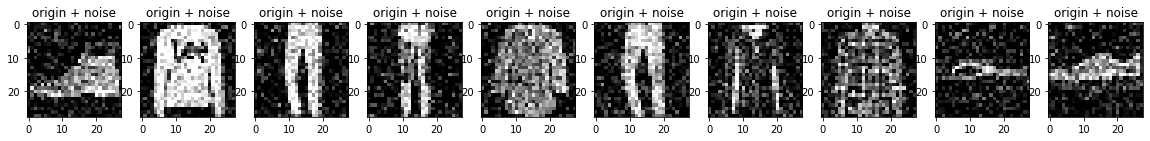

In [5]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
  ax = plt.subplot(1, n, i + 1)
  plt.title("origin + noise")
  plt.imshow(tf.squeeze(x_test_noisy[i])) #스퀴즈?
  plt.gray()
plt.show()

Encode에 Conv2D 레이어가 사용되고 
decoder에 conv2dTranspose 레이어가 사용될 예정.  
  
conv2d에서 16은 뭔지 (3,3)은 뭔지 padding에는 왜 same인지 
stride는 왜 2인지 확실히 알고 가자

In [6]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)), 
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [7]:
auto_encoder = Denoise()

In [8]:
auto_encoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
auto_encoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 21s 3ms/step - loss: 0.0333 - val_loss: 0.0095
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 3/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0082 - val_loss: 0.0077
Epoch 4/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0076 - val_loss: 0.0074
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 8/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 9/10
1569/1875 [========================>.....] - ETA: 0s - loss: 0.0068

In [ ]:
auto_encoder.encoder.summary()

28x28에서 7x7로 어떻게 다운샘플링되었는지 확인하라고 하는데 무슨말일까?  

14x14 옆에 16은 Conv2D에서 16값인 것 같은데, 맨 처음 차원을 늘린거랑 관계가 있는 것일까?

In [ ]:
auto_encoder.decoder.summary()

In [ ]:
encoded_imgs = auto_encoder.encoder(x_test).numpy()
decoded_imgs = auto_encoder.decoder(encoded_imgs).numpy()

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

몇몇개는 이제 원본(노이즈없는)과 굉장히 유사해졌다.  
  
그런데 noise를 걸고, encoding/decoding에서 cnn으로 방법변경한 이유는 무엇일까?  
  

+ 하지만 여전히 Lee글씨는 알아보기 어렵게 나올 뿐만 아니라, 슬리퍼의 경우는 앞쪽이 아예 날아가있다.  
이를 해결한 것은 없는 것일까?  